In [103]:
import pickle
import gzip
import os
import time
import copy
import cv2
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
class BoxModel(nn.Module):
    def __init__(self):
        super(BoxModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Predicting 2 coordinates (x, y)
            nn.Sigmoid()  # Sigmoid for normalized coordinates [0, 1]
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
box_model = torch.load("models/box_model.pth")

In [107]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
test_data = load_zipped_pickle("test.pkl")
train_data = load_zipped_pickle("train.pkl")

train_data_amateurs = []
train_data_experts = []
train_data_all = []

print("Dividing Data")
    
for item in tqdm(train_data):
    if(item['dataset'] == "amateur"):
        train_data_amateurs.append(item)
    else:
        train_data_experts.append(item)
    train_data_all.append(copy.deepcopy(item))
    
    
def eliminate_exes(data_point):  
    video = data_point['video'] 
    frames = data_point['frames'] 
    label = data_point['label']
    
    height, width, n_frames = video.shape
    
    cut_video = np.zeros((height, width, len(frames)))
    cut_label = np.zeros((height, width, len(frames)))
    
    for i, f in enumerate(frames):
        cut_video[:, :, i] = video[:, :, f]
        cut_label[:, :, i] = label[:, :, f]
        
    data_point['video'] = cut_video
    data_point['label'] = cut_label

def clean_data(data):
    for item in tqdm(data):
        eliminate_exes(item)
        
print("Removing Duds")
# one time run!!
clean_data(train_data_amateurs)
clean_data(train_data_experts)
clean_data(train_data_all)
print("Finished Loading Data\n")
print(f"Amateur Train set items:{len(train_data_amateurs)}")
print(f"Expert Train set items:{len(train_data_experts)}")
print(f"All Train set items:{len(train_data_all)}")

Dividing Data


100%|██████████| 65/65 [00:00<00:00, 160.47it/s]


Removing Duds


100%|██████████| 65/65 [00:00<00:00, 107.16it/s]

Finished Loading Data

Amateur Train set items:46
Expert Train set items:19
All Train set items:65


In [108]:
def extract_box_center_batch(box_batch):
    l = box_batch.shape[0]
    
    center_batch = []
    
    for i in range(l):
        center_batch.append( extract_box_center(box_batch[i,:,:]))
    
    center_batch = np.array(center_batch)
    
    return torch.FloatTensor(center_batch)

def extract_box_center(box):
    # Find indices where the box is True
    true_indices = np.argwhere(box)
    
    # Get the min and max indices for rows and columns
    min_row, min_col = true_indices.min(axis=0)
    max_row, max_col = true_indices.max(axis=0)
    
    # Compute the center of the bounding box
    center_x = (min_row + max_row) // 2
    center_y = (min_col + max_col) // 2
    
    return np.array([center_x / 255.0, center_y / 255.0])

def resize_boolean_array(b_item, shape=(256, 256)):
    # Resize directly using nearest-neighbor interpolation
    resized_item = cv2.resize(
        b_item.astype(np.uint8), 
        (shape[1], shape[0]), 
        interpolation=cv2.INTER_NEAREST
    )
    
    # Convert back to boolean
    return resized_item.astype(bool)

In [187]:
def crop_frame_and_label(frame, label, center):
    center = center*255.0
    cropped_frame = crop_image(frame, center.astype(int))
    cropped_label = crop_image(label, center.astype(int))
    
    return cropped_frame, cropped_label

def crop_image(image, center, shape=(128, 128)):
    # Initialize an empty cropped image with the desired output shape
    cropped_image = np.zeros(shape, dtype=float)
    
    # Get the center coordinates
    c_x = center[0]
    c_y = center[1]
    
    # Calculate the cropping boundaries around the center
    min_x = max(0, c_x - 64)  # Ensure min_x is within the image boundaries
    max_x = min(image.shape[0], c_x + 64)  # Ensure max_x doesn't exceed image size
    
    min_y = max(0, c_y - 64)  # Ensure min_y is within the image boundaries
    max_y = min(image.shape[1], c_y + 64)  # Ensure max_y doesn't exceed image size
    
    # Calculate the size of the valid crop region
    crop_height = max_x - min_x
    crop_width = max_y - min_y
    
    # Place the valid part of the image into the cropped image
    cropped_image[0:crop_height, 0:crop_width] = image[min_x:max_x, min_y:max_y]
    
    return cropped_image

In [140]:
class UNetDataset(Dataset):
    def __init__(self, frames_data, boxes_data, labels_data, transform=None):
        self.frames_data = frames_data  
        self.boxes_data = boxes_data
        self.labels_data = labels_data
        self.transform = transform

    def __getitem__(self, index):
        frame = self.frames_data[index]  # shape (height, width)
        box = self.boxes_data[index]
        label = self.labels_data[index]
        
        frame, box, label = self.transform(frame, box, label)
        center = extract_box_center(box)
        
        frame, label = crop_frame_and_label(frame, label, center)
            
        frame = torch.FloatTensor(frame)
        label = torch.FloatTensor(label)

        return frame, label

    def __len__(self):
        return len(self.frames_data)
    
class RandomRotation:
    def __init__(self, angle_range=(0, 360)):
        self.angle_range = angle_range

    def __call__(self, frame, box, label):
        angle = random.uniform(*self.angle_range) 
        height, width = frame.shape
        
        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
        
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (width, height))
        rotated_label = cv2.warpAffine(label, rotation_matrix, (width, height))
        
        rotated_box = cv2.warpAffine(box.astype(np.uint8), rotation_matrix, (width, height), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        rotated_box = rotated_box.astype(bool)
        
        return rotated_frame, rotated_box, rotated_label

In [142]:
def get_resized_list(data):
    f = []
    b = []
    l = []
    
    for item in tqdm(data):
        for i in range(item['video'].shape[2]):
            f_item = item['video'][:,:,i] 
            b_item = item['box']
            l_item = item['label'][:,:,i] 
            
            frame = cv2.resize(f_item.astype(np.uint8), (256, 256)) #/ 255.0
            f.append(frame)
            
            label = cv2.resize(l_item.astype(np.uint8), (256, 256)) #/ 255.0
            l.append(label)
 
            box = resize_boolean_array(b_item, shape=(256, 256))
            b.append(box)
 
    return f, b, l

f_a, b_a, l_a = get_resized_list(train_data_amateurs)
f_e, b_e, l_e = get_resized_list(train_data_experts)
f_ae, b_ae, l_ae = get_resized_list(train_data_all)

unet_amateur_train_dataset = UNetDataset(f_a, b_a, l_a, transform=RandomRotation())
unet_expert_train_dataset = UNetDataset(f_e, b_e, l_e, transform=RandomRotation())
unet_all_train_dataset = UNetDataset(f_ae, b_ae, l_ae, transform=RandomRotation())

100%|██████████| 65/65 [00:00<00:00, 173.27it/s]


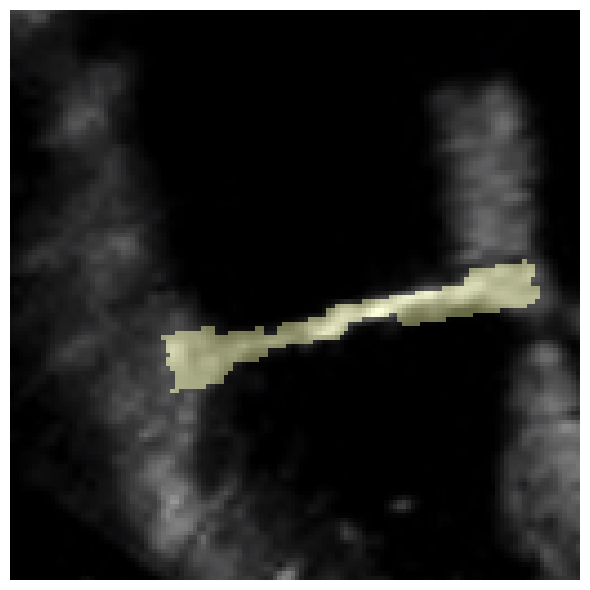

In [221]:
def print_BoxDataset_item(dataset, index):
    frame, label = dataset.__getitem__(index)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Display the frame (background)
    ax.imshow(frame, cmap='gray')
    ax.imshow(label, cmap='inferno', alpha=0.4) 
    ax.axis('off')
    plt.tight_layout()
    plt.show()
        
print_BoxDataset_item(unet_all_train_dataset, 6)